In [797]:
import os 
import pickle 
import numpy
from shutil import copyfile
import matplotlib.pyplot as plt 
%matplotlib  inline 

from pylab import *
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random

from scipy.io import loadmat

## Load dataset

In [4]:
!ls

Digit Classification.ipynb mnist_handout.py
caffe_classes.py           myalexnet.py
mnist_all.mat              snapshot50.pkl


In [140]:
#Load the MNIST digit data
M = loadmat("mnist_all.mat")

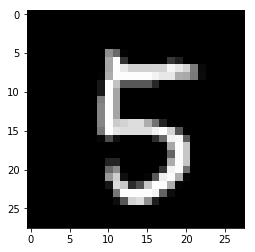

In [141]:
#Display the 150-th "5" digit from the training set
imshow(M["train5"][150].reshape((28,28)), cmap=cm.gray)
show()

In [857]:
def shuffle(X, t):
    pairs = list(zip(X,t))
    np.random.shuffle(pairs)
    Xs = np.asarray([x for x, t in pairs])
    ts = np.asarray([t for x, t in pairs])
    return Xs, ts


def get_datasets(M):
    X_train = []
    X_test = []
    t_train = []
    t_test = []

    for i in range(10):
        train_tag = "train"+str(i)
        test_tag = "test"+str(i)
        # training 
        l = M[train_tag].shape[0]
        X_train.extend(M[train_tag]/255.0)
        labels = np.zeros((l, 10))
        labels[:l, i] = np.ones(l)
        t_train.extend(labels)
        # test 
        l = M[test_tag].shape[0]
        X_test.extend(M[test_tag]/255.0)
        labels = np.zeros((l, 10))
        labels[:l, i] = np.ones(l)
        t_test.extend(labels)
    X_train, t_train = shuffle(X_train, t_train)
    X_test, t_test = shuffle(X_test, t_test)
    return X_train, t_train, X_test, t_test

In [858]:
X_train, t_train, X_test, t_test = get_datasets(M)

In [859]:
print(X_train.shape)
print(type(X_train))
print(t_train.shape)

(60000, 784)
<class 'numpy.ndarray'>
(60000, 10)


[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

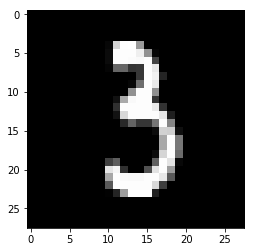

In [849]:
print(X_train[10])
print(t_train[10])
imshow(X_train[10].reshape((28,28)), cmap=cm.gray)
show()

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

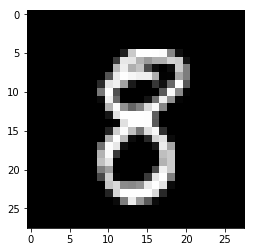

In [860]:
print(X_test[10])
print(t_test[10])
imshow(X_test[10].reshape((28,28)), cmap=cm.gray)
show()

## Part 1

In [893]:
# display 10 digits 

def display_digits(data, path="images/all_digits.png", index=150):
    plt.figure(1)
    plt.figure(figsize=(20, 7))
    i = 0
    for digit in range(10):
        # get teh valid theta image 
        img = data["train"+str(digit)][index].reshape((28,28))
        # plot image 
        i += 1
        plt.subplot(2, 5, i)
        plt.imshow(img, cmap=cm.gray)
        plt.title(str(digit))
        plt.grid(True)
    plt.savefig(path)
    plt.show()
    
def display_digits_grid(data, path="images/all_digits_grid.png", index=100, num=10):
    plt.figure(1)
    plt.figure(figsize=(20, 25))
    i = 0
    title = True
    for digit in range(10):
        for j in range(num):
            # get teh valid theta image 
            img = data["train"+str(digit)][index+j].reshape((28,28))
            # plot image 
            i += 1
            plt.subplot(10, num, i)
            if title:
                plt.title(str(digit))
                title = False  
            plt.imshow(img, cmap=cm.gray)
            plt.grid(True)
        title = True 
    plt.savefig(path)
    plt.show()

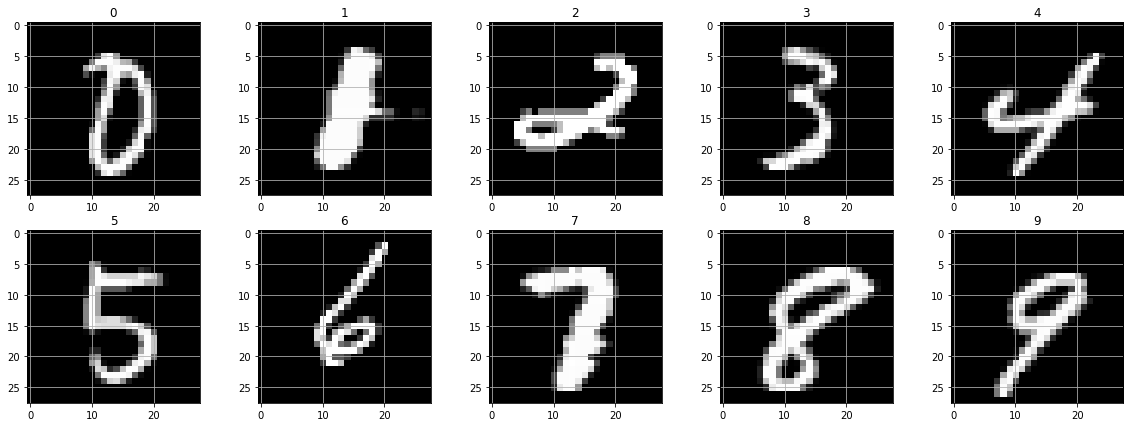

In [891]:
#Load the MNIST digit data
M = loadmat("mnist_all.mat")
display_digits(M)

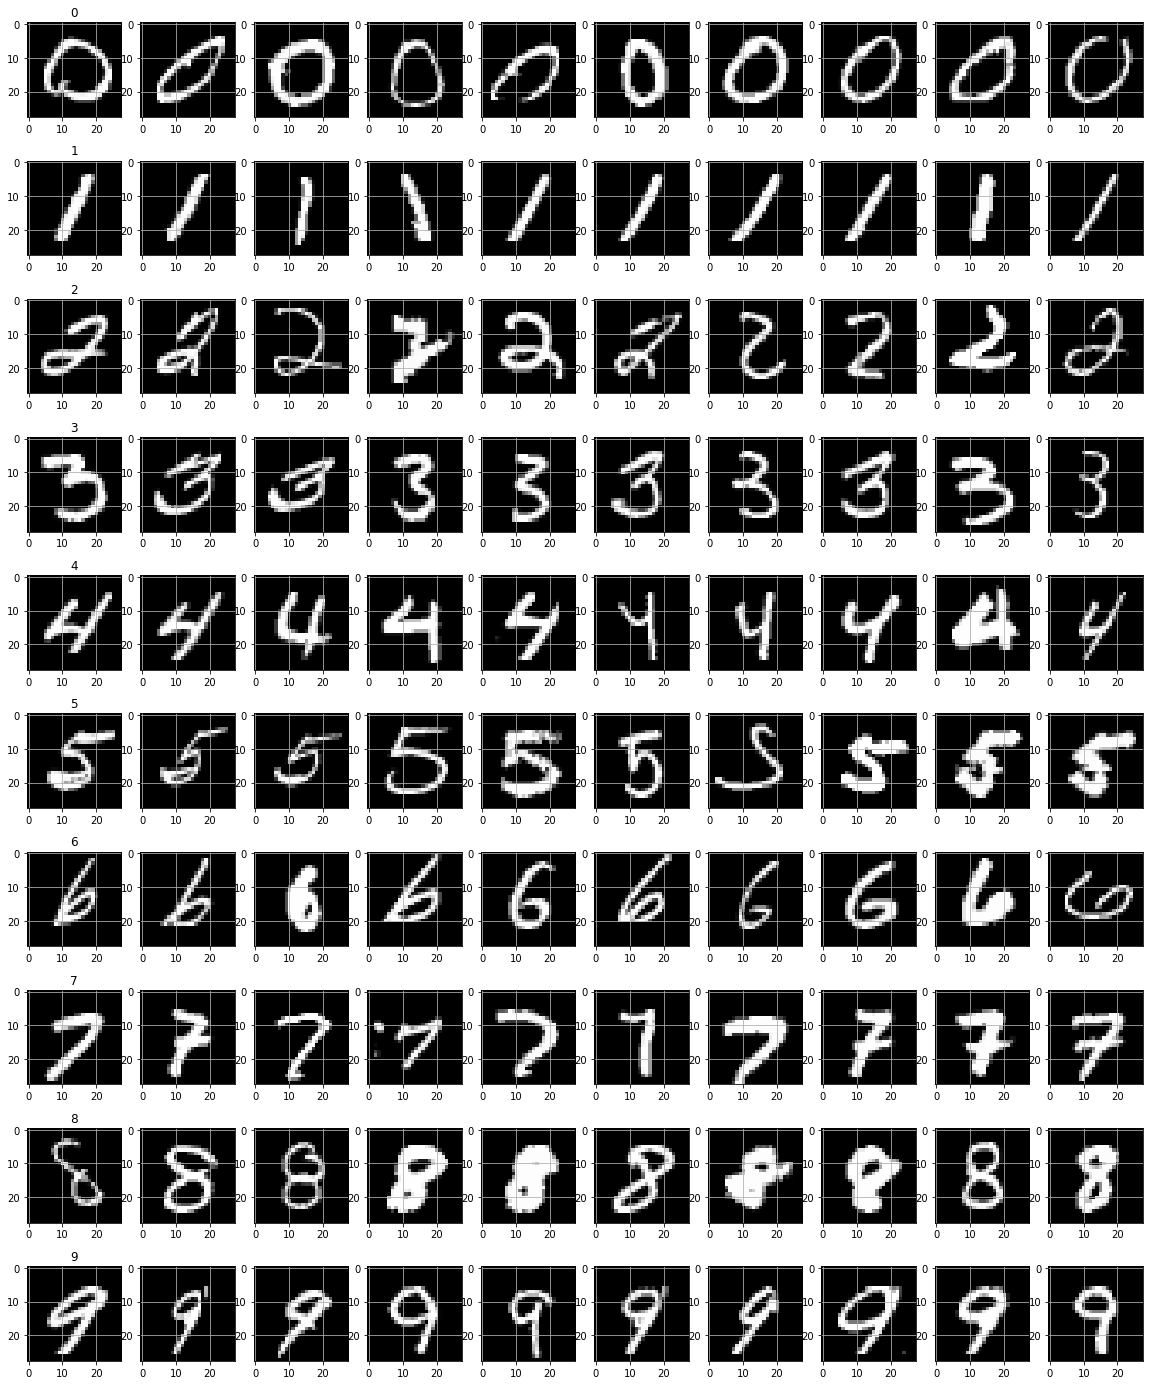

In [894]:
display_digits_grid(M)

## Part 2

In [863]:
# The Model 

class DigitNet(object):
    """ nn for digit classification
    """
    def __init__(self, in_dim=28*28, out_dim=10, X=None, t=None):
        # model hyperparameters
        self.in_dim = in_dim + 1
        self.out_dim = out_dim
        
        # parameter initialization
        # zero initializatinon
        self.weights = np.zeros((self.out_dim, self.in_dim))
        # random initialization 
        np.random.seed(0)
#         self.weights = np.random.normal(0, 0.1, (self.out_dim, self.in_dim))
#         self.weights = np.random.rand(self.out_dim, self.in_dim) 
        # Xavier initialization 
        self.weights[:, :-1] = np.random.normal(0, 2.0/(self.in_dim-1+self.out_dim), (self.out_dim, self.in_dim-1))
        self.weights[:, -1] = np.ones(self.out_dim)
        
        # default data
        self.X = self.augment_x(X) 
        self.t = t
        
        # training history
        self.loss_history = []
        self.acc_history = []
        
    def augment_x(self, X):
        # add extra column of 1 to X
        a_x = np.zeros((X.shape[0], X.shape[1]+1))
        a_x[:X.shape[0], :X.shape[1]] = X
        a_x[:X.shape[0], X.shape[1]] = np.ones(X.shape[0])
        return a_x
     
    def reset_weights(self, params=None):
        if params is not None:
            self.weights = params 
        else:
            np.random.seed(0)
            self.weights = np.random.rand(self.out_dim, self.in_dim)
            self.weights[:, :-1] = np.random.normal(0, 2.0/(self.in_dim-1+self.out_dim), (self.out_dim, self.in_dim-1))
            self.weights[:, -1] = np.ones(self.out_dim)

    def forward(self, X, weights=None):
        # Part 2 inference
        if X.shape[1] != self.in_dim:
            X = self.augment_x(X)
        output = np.matmul(X, self.weights.T) if weights is None else np.matmul(X, weights.T)
        #return exp(y)/tile(sum(exp(y),0), (len(y),1))
        output = np.exp(output - np.max(output, axis=1)[:, None])
        return output / np.sum(output, axis=1)[:, None]
#         rep = np.sum(exp(output), axis=1).reshape((output.shape[0], 1))
#         denom = np.tile(rep, output.shape[1])
#         return np.exp(output) / denom 
    
    def loss(self, y, t, minval=10**(-100)):
        # Part 3 sum of the negative log-probabilities
        logits = np.log(y.clip(min=minval))
#         return -sum(t*log(y)) 
        return -np.sum(t * logits)
#         return -np.sum(t * np.log(y))
    
    def accuracy(self, y, t):
        return np.sum(np.asarray(np.equal(np.argmax(y, axis=1), np.argmax(t, axis=1)).astype(int))) / float(y.shape[0])
    
    def gradient(self, X, y, t):
        # Part 3 finding gradients
        if X.shape[1] != self.in_dim:
            X = self.augment_x(X)
        loss_d = y - t
        w_grad = np.matmul(loss_d.T, X) 
        return w_grad 
    
    def gradient_descent(self, lr=0.0001, epochs=5000, threshold=10e-8, momentum=False, gamma=0.9, Xs=None, ts=None, display=True, disp_freq=500):
        # setup
        X = self.augment_x(Xs) if Xs is not None else self.X
        t = ts if ts is not None else self.t
        self.loss_history = []
        self.grad_history = []
        v = np.zeros((self.weights.shape[0], self.weights.shape[1]))
        lrate = lr
        lr_decay = False
        
        for i in range(epochs):
            y = self.forward(X)
            loss = self.loss(y, t)
            self.loss_history.append(loss)

            grad_w = self.gradient(X, y, t)
            if not momentum:
                self.weights -= lrate * grad_w
            else:
                # with momentum, discount rate gamma
                v = gamma * v + lrate * grad_w
                self.weights -= v

            acc = self.accuracy(y, t)
            self.acc_history.append(acc)
            if acc > 0.90 and not lr_decay:
                lrate /= 10
                lr_decay = True 
            
            if i % disp_freq == 0 and display:
                print("epoch %d/%d, loss %f, accuracy %f" % (i, epochs, loss, acc))
            if loss < threshold:
                print("loss drops below threshold %f" % threshold)
                break 
    
    def train(self, lr=0.0001, epochs=1000, threshold=10e-8, momentum=False, gamma=0.9, Xs=None, ts=None, display=True, disp_freq=500):
        self.gradient_descent(lr, epochs, threshold, momentum, gamma, Xs, ts, display, disp_freq)
    
    def evaluate(self, X, t):
        y = self.forward(X)
        loss = self.loss(y, t)
        acc = self.accuracy(y, t)
        print("loss is %f, accuracy is %f" % (loss, acc))
    
    def plot(self, path="images/performance.png", display=True):
        plt.figure(figsize=(20, 10))
        # loss curve 
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history)
        plt.title("Loss Curve")
        plt.xlabel("epochs")
        plt.ylabel("loss")
        # accuracy curve 
        plt.subplot(1, 2, 2)
        plt.plot(self.acc_history)
        plt.title("Accuracy Curve")
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        # display plot
        plt.grid(True)
        plt.savefig(path)
        if display:
            plt.show()
            
    def save(self, path="models/model.pkl"):
        with open(path, "wb") as f:
            pickle.dump(self.weights, f)
        print("model saved to "+path)

In [865]:
# utility functions 

def check_gradients(weight, h, model, num, threshold=10**(-3), coords=None, display=True, truncate=10**(-10)):
    """num: number of coordincates to variate and verify 
    """
    if coords is None:
        dim = model.weights.shape
        r = np.random.choice(range(dim[0]), num, replace=True)
        c = np.random.choice(range(dim[1]), num, replace=True)
        coords = zip(r, c)
    else:
        coords = coords
    finite_grad =  []
    
    # model gradients and loss 
    y = model.forward(X=model.X, weights=weight)
    grad = model.gradient(model.X, y, model.t)
    loss = model.loss(y, model.t)
    
    # variate gradients and loss 
    for item in coords:
        weight_copy = np.copy(weight)
        weight_copy[item[0], item[1]] += h
        y_c = model.forward(X=model.X, weights=weight_copy)
        loss_c = model.loss(y_c, model.t)
        grad_c = (loss_c - loss) / h
        if grad_c > truncate and grad[item[0], item[1]] > truncate:
            finite_grad.append((item, grad_c))
        
    # compute deviations
    grad_diff_list = [abs((grad[coord[0], coord[1]] - g_v) / (abs(g_v) + abs(grad[coord[0], coord[1]])))  for (coord, g_v) in finite_grad]
    if display:
        print("deviations are ")
        for i in range(len(finite_grad)):
            print("weights", finite_grad[i][0], ": ", grad_diff_list[i])
    return True if np.max(np.asarray(grad_diff_list)) < threshold else False, coords, grad_diff_list 
    

## Pipeline

In [866]:
# simulation data
model1 = DigitNet(X=X_train, t=t_train)

In [868]:
check_gradients(weight=model1.weights, h=0.0001, model=model1, num=10)

deviations are 
weights (4, 388) :  4.04237876115e-05
weights (2, 682) :  2.07355816874e-05
weights (8, 415) :  2.2496652869e-05
weights (1, 100) :  2.0717146635e-05
weights (5, 451) :  3.0673209334e-05


(True,
 [4.0423787611450271e-05,
  2.0735581687363364e-05,
  2.2496652869042149e-05,
  2.0717146634961943e-05,
  3.0673209333980769e-05])

In [869]:
model1.train(epochs=4000, momentum=False)

epoch 0/4000, loss 138348.028188, accuracy 0.102717
epoch 500/4000, loss 22865.711313, accuracy 0.915683
epoch 1000/4000, loss 18045.096781, accuracy 0.923267
epoch 1500/4000, loss 16379.755457, accuracy 0.926533
epoch 2000/4000, loss 15710.510581, accuracy 0.928667
epoch 2500/4000, loss 15389.233292, accuracy 0.929783
epoch 3000/4000, loss 15200.450949, accuracy 0.930717
epoch 3500/4000, loss 15068.385054, accuracy 0.931283


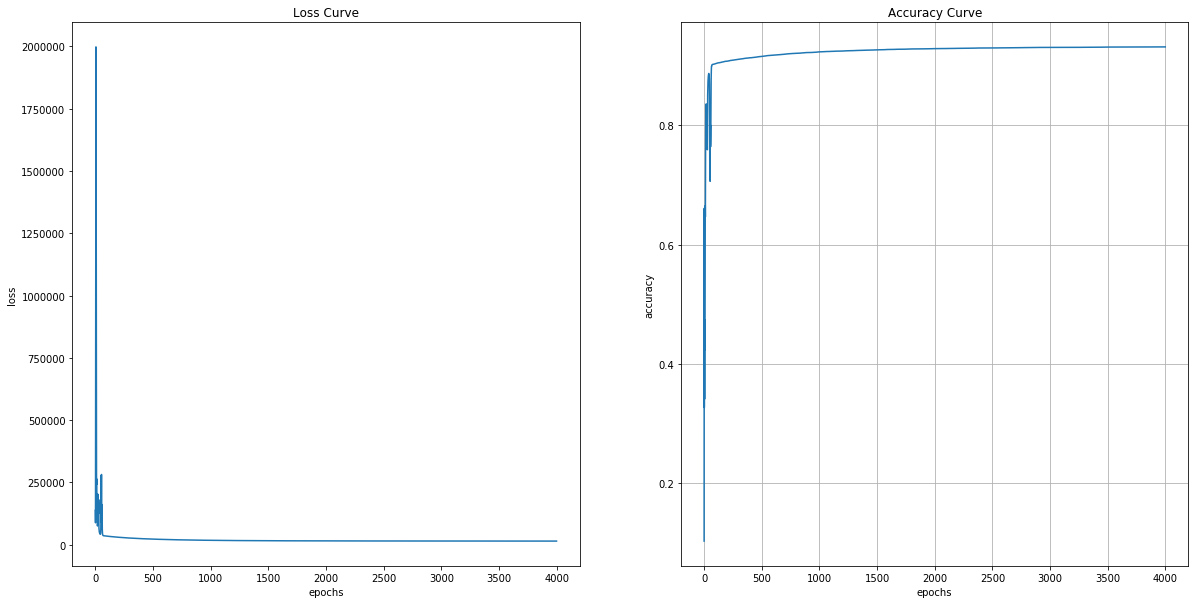

loss is 2666.531776, accuracy is 0.926000


In [870]:
model1.plot(path="images/performance_new.png")
model1.evaluate(X_test, t_test)

In [876]:
# save models, training takes too long 
model1.save(path="models/model1-7.pkl")

model saved to models/model1-6.pkl


In [872]:
model2 = DigitNet(X=X_train, t=t_train)
model2.train(epochs=4000, momentum=True)

epoch 0/4000, loss 138348.028188, accuracy 0.102717
epoch 500/4000, loss 72130.759372, accuracy 0.919033
epoch 1000/4000, loss 40103.550447, accuracy 0.924600
epoch 1500/4000, loss 25801.014254, accuracy 0.928167
epoch 2000/4000, loss 19215.854814, accuracy 0.932467
epoch 2500/4000, loss 16295.428612, accuracy 0.935267
epoch 3000/4000, loss 14926.391206, accuracy 0.936783
epoch 3500/4000, loss 14226.975153, accuracy 0.938017


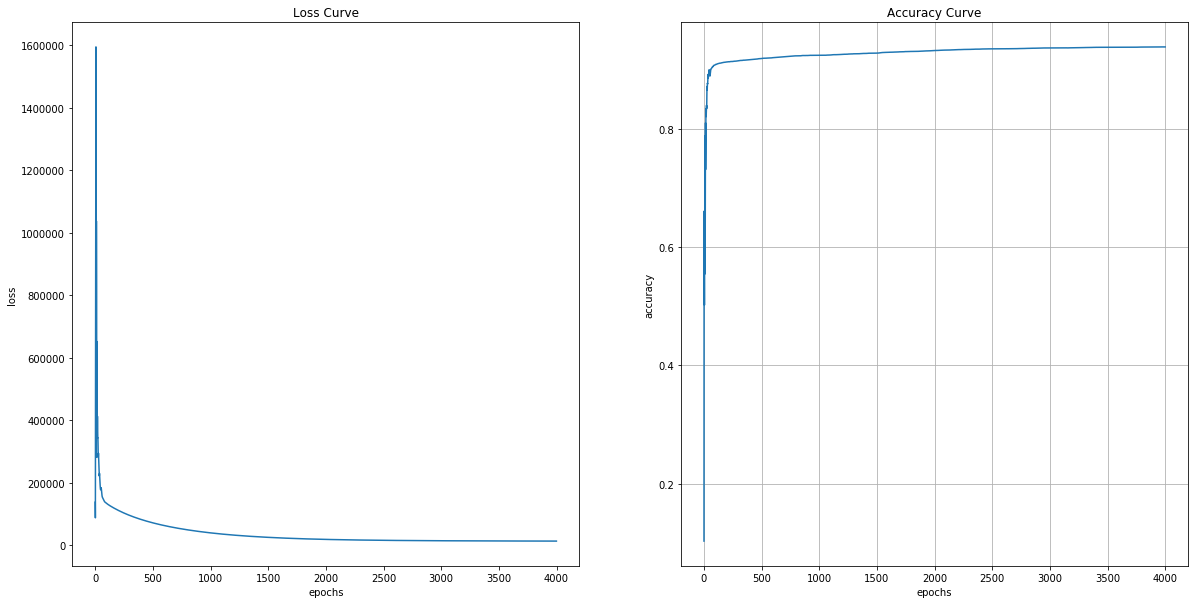

loss is 2989.018423, accuracy is 0.925500


In [873]:
model2.plot(path="images/performance_momentum_new.png")
model2.evaluate(X_test, t_test)

In [875]:
model2.save(path="models/model2-7.pkl")

model saved to models/model2-6.pkl


## Visualize weights 

In [877]:
def visualize_weights(model, path="images/weights.png", index=150):
    plt.figure(1)
    plt.figure(figsize=(20, 7))
    i = 0
    for digit in range(10):
        # get the weights 
        img = model.weights[i,:-1].reshape((28,28)) * 255.0
        # plot image 
        i += 1
        plt.subplot(2, 5, i)
        plt.imshow(img, cmap=cm.gray)
        plt.title(str(digit))
        plt.grid(True)
    plt.savefig(path)
    plt.show()

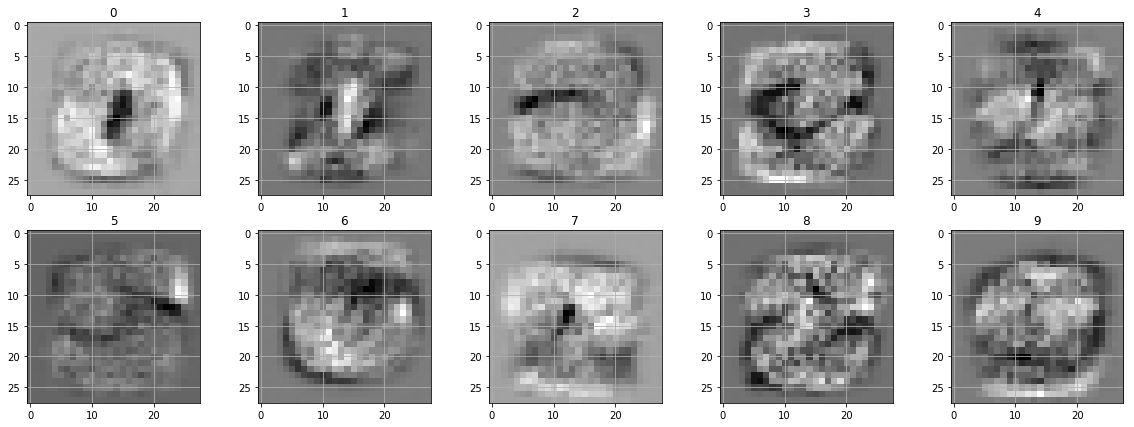

In [878]:
visualize_weights(model1, path="images/weights1.png")

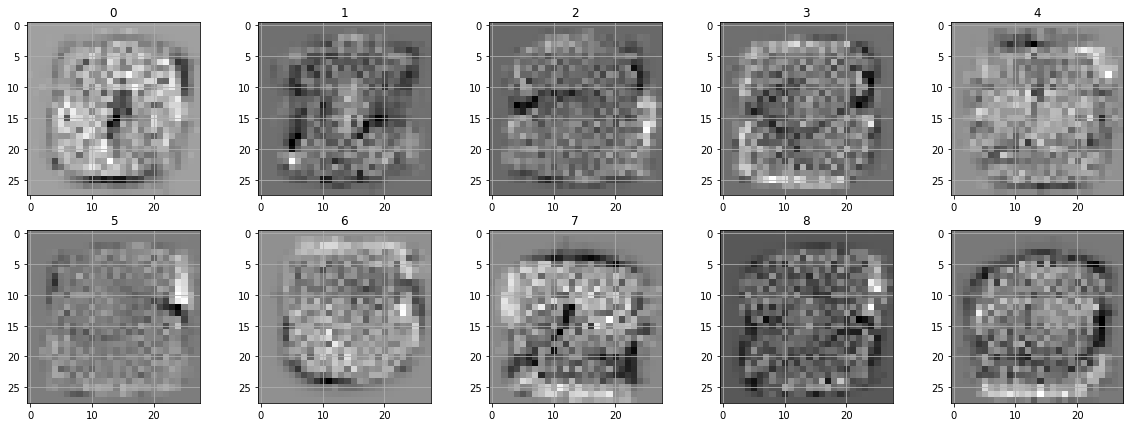

In [879]:
visualize_weights(model2, path="images/weights2.png")

## Contour plots

In [704]:
def select_coords(model, num=2):
    # choose coordinates    
    dim = model.weights.shape
    r_range = range(int(dim[0]/8*3), int(dim[0]/8*5))
    c_range = range(int(dim[1]/16*7), int(dim[1]/16*9))
    np.random.seed(4)
    r = list(np.random.choice(r_range, num, replace=True))
    c = list(np.random.choice(c_range, num, replace=True))
    coords = list(zip(r, c))
    return coords
    

def plot_contour(model, coords, path="images/contour.png"): 
    dim = model.weights.shape
    
    # decompose to optimize 
    weights_c = np.copy(model.weights)
    print(weights_c[coords[0][0], coords[0][1]])
    print(weights_c[coords[1][0], coords[1][1]])
    
    w1s = np.arange(-1, 1, 0.05) + weights_c[coords[0][0], coords[0][1]]
    w2s = np.arange(-1, 1, 0.05) + weights_c[coords[1][0], coords[1][1]]
    
    weights_c[coords[0][0], coords[0][1]] = 0
    weights_c[coords[1][0], coords[1][1]] = 0
    output_constant_portion = np.dot(model.X, weights_c.T)
    weights_temp = np.zeros((dim[0], dim[1]))
    
    
    # helper function 
    def get_loss(w1, w2):   
        weights_temp[coords[0][0], coords[0][1]] = w1
        weights_temp[coords[1][0], coords[1][1]] = w2
        output_varied_portion = np.dot(model.X, weights_temp.T)
        output = output_constant_portion + output_varied_portion
        output = np.exp(output - np.max(output, axis=1)[:, None]) 
        y = output / np.sum(output, axis=1)[:, None]
        loss = model.loss(y, model.t)
        return loss 
    
    # loss contours 
    w1z, w2z = np.meshgrid(w1s, w2s)
    C = np.zeros([w1s.size, w2s.size])
    for i, w1 in enumerate(w1s):
        for j, w2 in enumerate(w2s):
            C[j,i] = get_loss(w1, w2)
    
    # plot contour 
    plt.figure(figsize=(10,10))
    CS = plt.contour(w1z, w2z, C, camp=cm.coolwarm)
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title('Contour Plot')
    plt.xlabel("w1")
    plt.ylabel('w2')
    plt.savefig(path)
    plt.show()
    
    # return results to keep track 
    return w1z, w2z, C

In [381]:
# def plot_contour_optimized(model, num=2, path="images/contour.png"):
    
#     # choose coordinates    
#     dim = model.weights.shape
#     r_range = range(int(dim[0]/8*3), int(dim[0]/8*5))
#     c_range = range(int(dim[1]/8*3), int(dim[1]/8*5))
#     np.random.seed(1)
#     r = list(np.random.choice(r_range, num, replace=True))
#     c = list(np.random.choice(c_range, num, replace=True))
#     coords = list(zip(r, c))
#     # weights ranges 
#     weights_c = np.copy(model.weights)
#     print(coords)
#     print(weights_c[coords[0][0], coords[0][1]])
#     print(weights_c[coords[1][0], coords[1][1]])
#     w1_range = np.linspace(-20.0, 20.0, 100) + weights_c[coords[0][0], coords[0][1]]
#     w2_range = np.linspace(-20.0, 20.0, 100) + weights_c[coords[1][0], coords[1][1]]
#     # loss contours 
#     ### for optimization 
#     weights_c[coords[0][0], coords[0][1]] = 0
#     weights_c[coords[1][0], coords[1][1]] = 0
#     output_constant_portion = np.dot(model.X, weights_c.T)
#     weights_temp = np.zeros((dim[0], dim[1]))
#     ### 
#     def vectorized_loss(w1, w2):   
#         weights_temp[coords[0][0], coords[0][1]] = w1
#         weights_temp[coords[1][0], coords[1][1]] = w2
#         output_varied_portion = np.dot(model.X, weights_temp.T)
#         output = output_constant_portion + output_varied_portion
#         output = np.exp(output - np.max(output, axis=1)[:, None]) 
#         y = output / np.sum(output, axis=1)[:, None]
#         loss = model.loss(y, model.t)
#         return loss 
#     lossfunc = np.vectorize(vectorized_loss, otypes=[np.float])
#     W1, W2 = np.meshgrid(w1_range, w2_range)
#     Loss = lossfunc(W1, W2)
    
#     # plot contour 
#     plt.figure(figsize=(15,15))
#     cp = plt.contour(W1, W2, Loss)
#     plt.clabel(cp, inline=True, fontsize=10)
#     plt.title('Contour Plot')
#     plt.xlabel("w1")
#     plt.ylabel('w2')
#     plt.savefig(path)
#     plt.show()

In [705]:
coords = select_coords(model1)
coords

[(5, 398), (5, 412)]

-0.336696479899
-0.207287771804


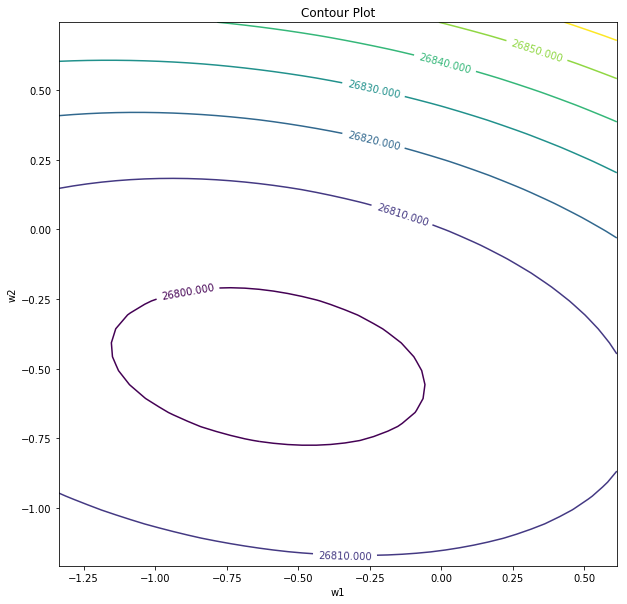

In [706]:
w1z, w2z, C = plot_contour(model1, coords, path="images/contour.png")

In [703]:
d = {"w1z":w1z, "w2z":w2z, "C":C}
with open("contour_data_seed4.pkl", "wb") as f:
    pickle.dump(d, f)

## Plot contour with trajectory

In [721]:
def gradient_descent_trajectory(model, coords, epochs=20, lr=0.0005, momentum=False, gamma=0.9, Xs=None, ts=None):
    X = model.augment_x(Xs) if Xs is not None else model.X
    t = ts if ts is not None else model.t 
    grad_history = []
    v = np.zeros((model.weights.shape[0], model.weights.shape[1]))
    
    weights_c = np.copy(model.weights)
    w1 = 0.25 #weights_c[coords[0][0], coords[0][1]]    
    w2 = 0.50 #weights_c[coords[1][0], coords[1][1]]
    # seed 3, 1, -2
    grad_history.append((w1, w2))
    
    for i in range(epochs):
        y = model.forward(X, weights=weights_c)
        loss = model.loss(y, t)

        grad_w = model.gradient(X, y, t)
        if not momentum:
            weights_c[coords[0][0], coords[0][1]] -= lr * grad_w[coords[0][0], coords[0][1]]
            weights_c[coords[1][0], coords[1][1]] -= lr * grad_w[coords[1][0], coords[1][1]]
        else:
            # with momentum, discount rate gamma
            v = gamma * v + lr * grad_w
            weights_c[coords[0][0], coords[0][1]] -= v[coords[0][0], coords[0][1]]
            weights_c[coords[1][0], coords[1][1]] -= v[coords[1][0], coords[1][1]]
        w1 = weights_c[coords[0][0], coords[0][1]]
        w2 = weights_c[coords[1][0], coords[1][1]]
        grad_history.append((w1, w2))
    return grad_history

In [722]:
trajectory = gradient_descent_trajectory(model1, coords, epochs=20, lr=0.03)  # 0.0125 works
trajectory
# seed 3, 0.01

[(0.25, 0.5),
 (-0.52375261942560059, -0.75570818082282565),
 (-0.50010642212145195, -0.32652595209394414),
 (-0.58325115071172695, -0.63251919294616155),
 (-0.55972163721052914, -0.39859501771375749),
 (-0.5990757927062621, -0.56780646204684204),
 (-0.58268082106898011, -0.44012423229907821),
 (-0.60219811556592096, -0.53330712795653501),
 (-0.59204051720047635, -0.46352500329933988),
 (-0.60205169908148226, -0.51473156831112177),
 (-0.59609027916930346, -0.47655707338932674),
 (-0.60134649541310836, -0.50466439354672732),
 (-0.59794623944233083, -0.48376737616542259),
 (-0.60074914086117837, -0.49918553552473482),
 (-0.59884066079511766, -0.48774153393655212),
 (-0.6003504677203837, -0.49619591066788299),
 (-0.59928931533351715, -0.48992707378476269),
 (-0.60010783224320063, -0.49456189365776138),
 (-0.59952112027714599, -0.49112735726753598),
 (-0.599966669184404, -0.49366789146203893),
 (-0.59964337976881754, -0.49178600241342674)]

In [729]:
trajectory_m = gradient_descent_trajectory(model1, coords, epochs=40, lr=0.001, momentum=True, gamma=0.8) # 0.005 works
trajectory_m
# seed 3, 0.001, 0.85

[(0.25, 0.5),
 (-0.34293168454958589, -0.22556845210457629),
 (-0.35391448339884019, -0.25737768765591057),
 (-0.36827557378153147, -0.29810286267279584),
 (-0.38479891554493906, -0.3435194461487191),
 (-0.40244396504052088, -0.38996607723009491),
 (-0.42035575072080172, -0.43445024518722858),
 (-0.43786418497410678, -0.4746921701410971),
 (-0.45447454794182673, -0.50911685058422729),
 (-0.46985133723027334, -0.53680547858066219),
 (-0.48379768680611607, -0.55741764223187984),
 (-0.49623237848040286, -0.57109512453896483),
 (-0.50716617151965815, -0.57835690410994423),
 (-0.51667882637734541, -0.5799934068281426),
 (-0.52489784738094125, -0.57696635652851302),
 (-0.53197964712647827, -0.57031888332567249),
 (-0.53809355656115221, -0.56109897433834433),
 (-0.54340887253696901, -0.55029795414297122),
 (-0.54808494657195295, -0.53880449238653927),
 (-0.55226417034771069, -0.52737366574302647),
 (-0.55606760096670282, -0.51660985140479365),
 (-0.55959288890555692, -0.5069616923810335),
 (-

In [730]:
def plot_contour_trajectory(w1z, w2z, C, gd, momentum_gd, path="images/contour_trajectory.png"):
    plt.figure(figsize=(20,20))
    CS = plt.contour(w1z, w2z, C, camp=cm.coolwarm)
    plt.plot([a for a, b in gd], [b for a,b in gd], 'yo-', label="No Momentum")
    plt.plot([a for a, b in momentum_gd], [b for a,b in momentum_gd], 'go-', label="Momentum")
    
    # seed 2
#     s = C.shape
#     CS = plt.contour(w1z[int(s[0]/16*8):int(s[0]/16*9), int(s[1]/16*9):int(s[1]/16*10)],
#                      w2z[int(s[0]/16*8):int(s[0]/16*9), int(s[1]/16*9):int(s[1]/16*10)],
#                      C[int(s[0]/16*8):int(s[0]/16*9), int(s[1]/16*9):int(s[1]/16*10)], camp=cm.coolwarm)
#     plt.plot([a for a, b in gd][1:], [b for a,b in gd][1:], 'yo-', label="No Momentum")
#     plt.plot([a for a, b in momentum_gd][1:], [b for a,b in momentum_gd][1:], 'go-', label="Momentum")
    
#     s = C.shape
#     CS = plt.contour(w1z[int(s[0]/16*8):int(s[0]/16*9), int(s[1]/16*9):int(s[1]/16*10)],
#                      w2z[int(s[0]/16*8):int(s[0]/16*9), int(s[1]/16*9):int(s[1]/16*10)],
#                      C[int(s[0]/16*8):int(s[0]/16*9), int(s[1]/16*9):int(s[1]/16*10)], camp=cm.coolwarm)
#     plt.plot([a for a, b in gd][1:], [b for a,b in gd][1:], 'yo-', label="No Momentum")
#     plt.plot([a for a, b in momentum_gd][1:], [b for a,b in momentum_gd][1:], 'go-', label="Momentum")
    
    
    plt.xlabel("w1")
    plt.ylabel('w2')
    plt.legend(loc='upper left')
    plt.title('Contour plot')
    plt.savefig(path)
    plt.show()

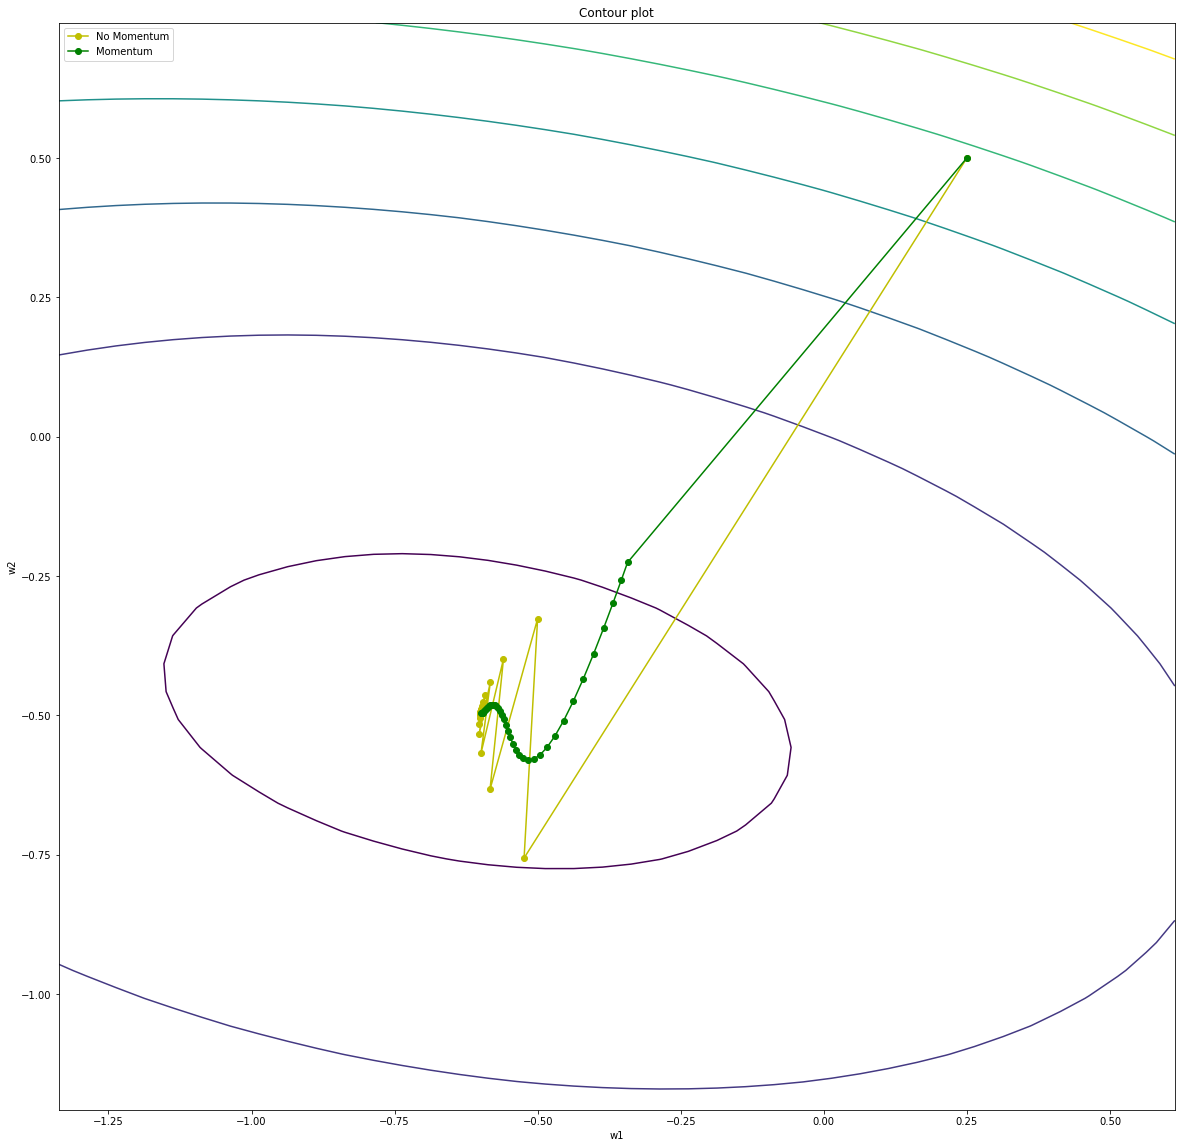

In [731]:
plot_contour_trajectory(w1z, w2z, C, trajectory, trajectory_m, path="images/contour_trajectory_seed4_all.png")

## Part 7 backprop comparisons 